# Instalação

In [1]:
#!pip install xcompact3d_toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalli

# Computação e Visualização

Esse tutorial é uma introdução de como computar, selecionar dados e plot com objetos xarray oferecidos pelo xcompact3d-toolbox.

Comece por importar as bibliotecas:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import xcompact3d_toolbox as x3d

## Why xarray?

As estruturas de dados são providas por [xarray](http://docs.xarray.dev/en/stable/index.html), que atribui rótulos de dimensão, coordenadas e atributos sob NumPy arrays. E utiliza [dask](https://dask.org/) para computação paralela.
O objetivo é acelerar o desenvolvimento e customização do pós-processamento.

Adicionamente, xcompact3d-toolbox prove funcionalidades para [DataArray](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.array.X3dDataArray) e [Dataset](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.array.X3dDataset).

Mais detalhes da biblioteca [xarray](http://docs.xarray.dev/en/stable/index.html) estão disponíveis em [Overview: Why xarray?](http://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) e [Quick overview](http://docs.xarray.dev/en/stable/getting-started-guide/quick-overview.html).

## Exemplo - Escoamento ao redor de um cilindro

Se usará como base o caso do escoamento ao redor de um cilindro disponível no [banco de dados online](https://github.com/fschuch/xcompact3d_toolbox_data).

In [2]:
dataset, prm = x3d.tutorial.open_dataset("cylinder", cache=True, cache_dir="./example/")

Primeiro, visualiza-se o `dataset`:

In [3]:
dataset

<xarray.Dataset> Size: 79MB
Dimensions:  (i: 2, x: 257, y: 128, t: 201)
Coordinates:
  * x        (x) float64 2kB 0.0 0.07812 0.1562 0.2344 ... 19.84 19.92 20.0
  * y        (y) float64 1kB 0.0 0.09375 0.1875 0.2812 ... 11.72 11.81 11.91
  * t        (t) float64 2kB 0.0 0.75 1.5 2.25 3.0 ... 147.8 148.5 149.2 150.0
  * i        (i) <U1 8B 'x' 'y'
Data variables:
    u        (i, x, y, t) float32 53MB ...
    pp       (x, y, t) float32 26MB ...
    epsi     (x, y) float32 132kB ...
Attributes:
    xcompact3d_version:          v3.0-397-gff531df
    xcompact3d_toolbox_version:  1.0.1
    url:                         https://github.com/fschuch/xcompact3d_toolbo...
    dataset_license:             MIT License

O banco de dados está no formato do [xarray.Dataset](http://docs.xarray.dev/en/stable/generated/xarray.Dataset.html#xarray.Dataset) com as variáveis `u` (vetor de velocidade), `pp` (pressão) e `epsi` (que descreve a geométria), suas coordenadas (`x`, `y`, `t` e `i`) e alguns metadados como a versão do Xcompact3d usado para rodar a simulação e a `url` onde pode-se achar a simulação.

Cada variável e coordenada pode ser acessada com a notação de ponto (i.g., `snapshot.pp`, `snapshot.u`, `snapshot.x`) ou com colchetes (i.g., `snapshot["pp"]`, `snapshot["u"]`, `snapshot["x"]`).

Começando pelo `epsi`, que representa a geométria (é 1 dentro do cilindro e 0 fora), pode-se visualiza-lo com o método [plot](http://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.html):

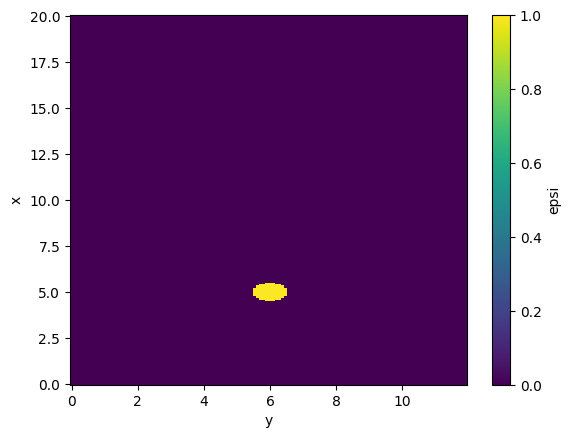

In [4]:
dataset.epsi.plot()

No exemplo, o array bidimensional é plotado com `.plot()`, que chama automaticamente [xarray.plot.pcolormesh()](http://docs.xarray.dev/en/stable/generated/xarray.plot.pcolormesh.html#xarray.plot.pcolormesh).

As funcionalidades do xarray para costruir gráficos utiliza como base a biblioteca [matplotlib](https://matplotlib.org/).

Para melhorar a figura, modifica-se os axis do gráfico com `x` para o axis `x`, a coordenada `y` para o axis `y`, e definindo o aspecto do gráfico para `equal`.

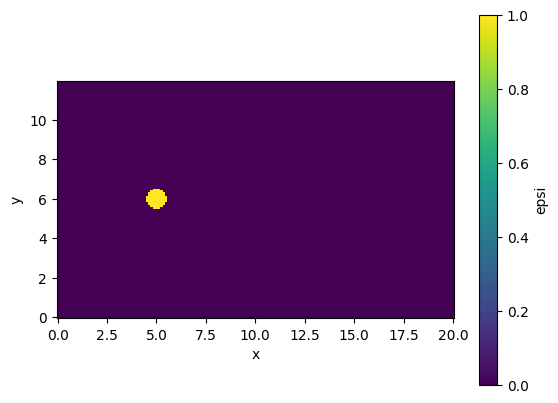

In [5]:
ax = dataset.epsi.plot(x="x", y="y")
ax.axes.set_aspect("equal")

Para os campos de velocidade e pressão se iguinora os valores dentro do cilindro. Isso pode ser feito atribuindo `np.NaN` para os valores de `u` e `pp` onde `epsi` é zero.

Para tal tarefa, pode-se usar o método [xarray.Dataset.where](http://docs.xarray.dev/en/stable/generated/xarray.Dataset.where.html).

In [6]:
for var in ["u", "pp"]:
    dataset[var] = dataset[var].where(dataset.epsi == 0, np.nan)

Nota-se a expressividade do xarray quando essa comparação é feita. Lembrando que `epsi` é 2D (x, y), `pp` é 3D (x, y, t) e `u` é 4D (i, x, y, t). Isso só é possível porque xarray transmite os valores de `epsi` em cada ponto da coordenada `t` e `i`.

Outra flexibilidade do xarray é que pode-se selecionar dados baseados nas coordenadas e não apenas nos indices como numpy arrays.

Na célula a baixo se seleciona um ponto do domínio usando o método [select](http://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html). Observa-se que pode-se monitorar esse ponto durante toda a evolução da simulação:

In [7]:
dataset.sel(x=10.0, y=6.0, method="nearest")

<xarray.Dataset> Size: 4kB
Dimensions:  (i: 2, t: 201)
Coordinates:
    x        float64 8B 10.0
    y        float64 8B 6.0
  * t        (t) float64 2kB 0.0 0.75 1.5 2.25 3.0 ... 147.8 148.5 149.2 150.0
  * i        (i) <U1 8B 'x' 'y'
Data variables:
    u        (i, t) float32 2kB 1.005 0.9915 0.987 ... 0.838 -0.5676 -0.749
    pp       (t) float32 804B 0.0 -0.003727 -0.001281 ... -0.5678 -0.2354
    epsi     float32 4B 0.0
Attributes:
    xcompact3d_version:          v3.0-397-gff531df
    xcompact3d_toolbox_version:  1.0.1
    url:                         https://github.com/fschuch/xcompact3d_toolbo...
    dataset_license:             MIT License

Pode-se combinar os dois métodos em apenas uma linha de código.

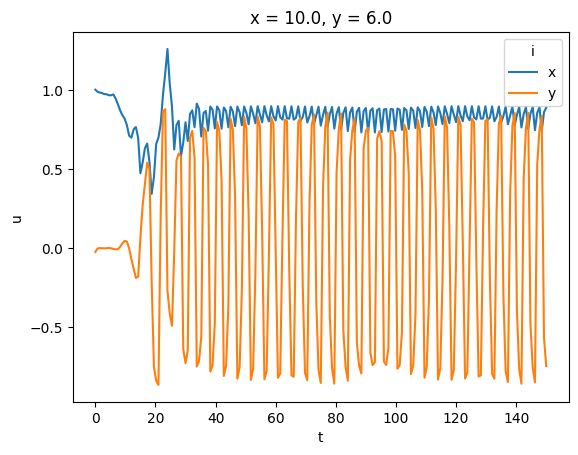

In [9]:
dataset.u.sel(x=10.0, y=6.0, method="nearest").plot(x="t", hue="i");

Em outro exemplo, se plotou a [média](http://docs.xarray.dev/en/stable/generated/xarray.DataArray.mean.html) temporal ($60 \le t \le 150$) da velocidade vertical onde $x=10$:

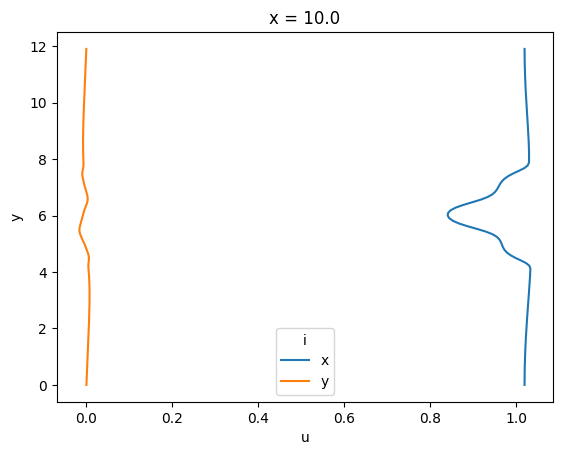

In [11]:
dataset.u.sel(x=10.0, t=slice(60.0, 150.0)).mean("t").plot(y="y", hue="i");

Pode-se observar que xarray permite se referenciar as coordenadas pelo seu nome ao invés do seu axis número.

Extendendo esse conceito, se cálcula a evolução temporal da energia cinética. Dada pela equação:

$$
k = \int_V \dfrac{u_iu_i}{2} dV.
$$

Com o código:

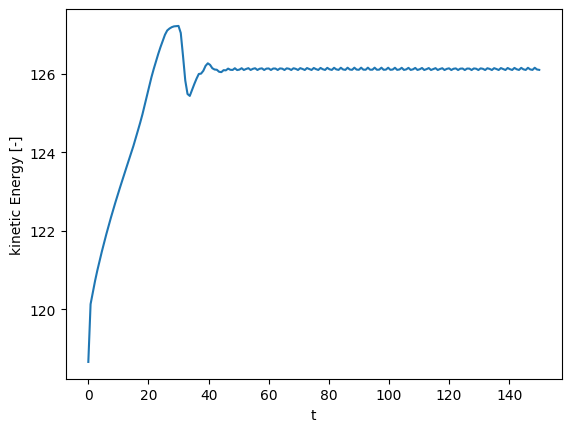

In [13]:
dataset["kinetic_energy"] = ((dataset.u**2.0).sum("i").x3d.simpson("x", "y")) * 0.5
dataset["kinetic_energy"].attrs = {"name": "k", "long_name": "kinetic Energy", "units": "-"}
dataset["kinetic_energy"].plot();

No código acima:

* Se cálculo a equação para toda a série temporal com um código bem sucinto;

* Foi incluindo atributos para descrever o que foi computado. Esses informações foram automaticamente incluidas no plot;

* Fez se o gráfico da energia cinética.

Pode-se obter as dimensões para o cálculo da integral volumétrica com:

In [14]:
V_coords = [dim for dim in dataset.u.coords if dim in "xyz"]
V_coords

['x', 'y']

reescrevendo o exemplo anterior pode-se obter uma versão para o caso n-dimensional:

In [15]:
dataset["kinetic_energy"] = ((dataset.u**2.0).sum("i").x3d.simpson(*V_coords)) * 0.5
dataset["kinetic_energy"].attrs = {"name": "k", "long_name": "kinetic Energy", "units": "-"}

Voltando ao plot 2D, para o vetor de velocidade `u`, para o intervalo de tempo $60 \le t \le 150$ ([sel](http://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html)), calcular a média temporal ([mean](https://docs.xarray.dev/en/stablegenerated/xarray.DataArray.mean.html)) e montar o gráfico ([plot](https://docs.xarray.dev/en/stablegenerated/xarray.DataArray.plot.html)):

/tmp/ipython-input-1112291274.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


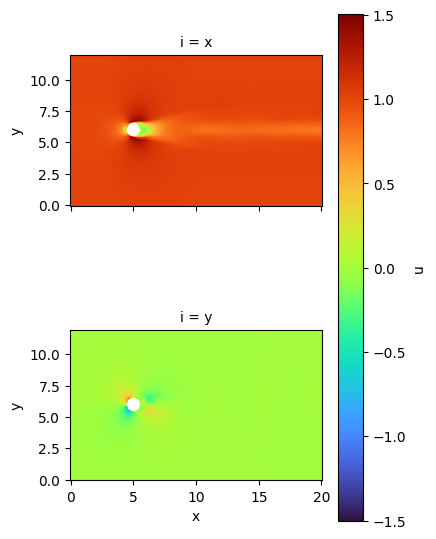

In [16]:
g = dataset.u.sel(t=slice(60.0, 150.0)).mean("t").plot(x="x", y="y", row="i", cmap="turbo", rasterized=True)
for ax in g.axes.flat:
    ax.axes.set_aspect("equal")

Para ver a evolução temporal de `u` pode-se usar [isel](https://docs.xarray.dev/en/stablegenerated/xarray.DataArray.isel.html) com [slice](https://docs.python.org/3/library/functions.html#slice) para selecionar a cada 40 pontos no tempo (do contrário seriam figuras demais) e [plot](https://docs.xarray.dev/en/stablegenerated/xarray.DataArray.plot.html):

/tmp/ipython-input-2886538870.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


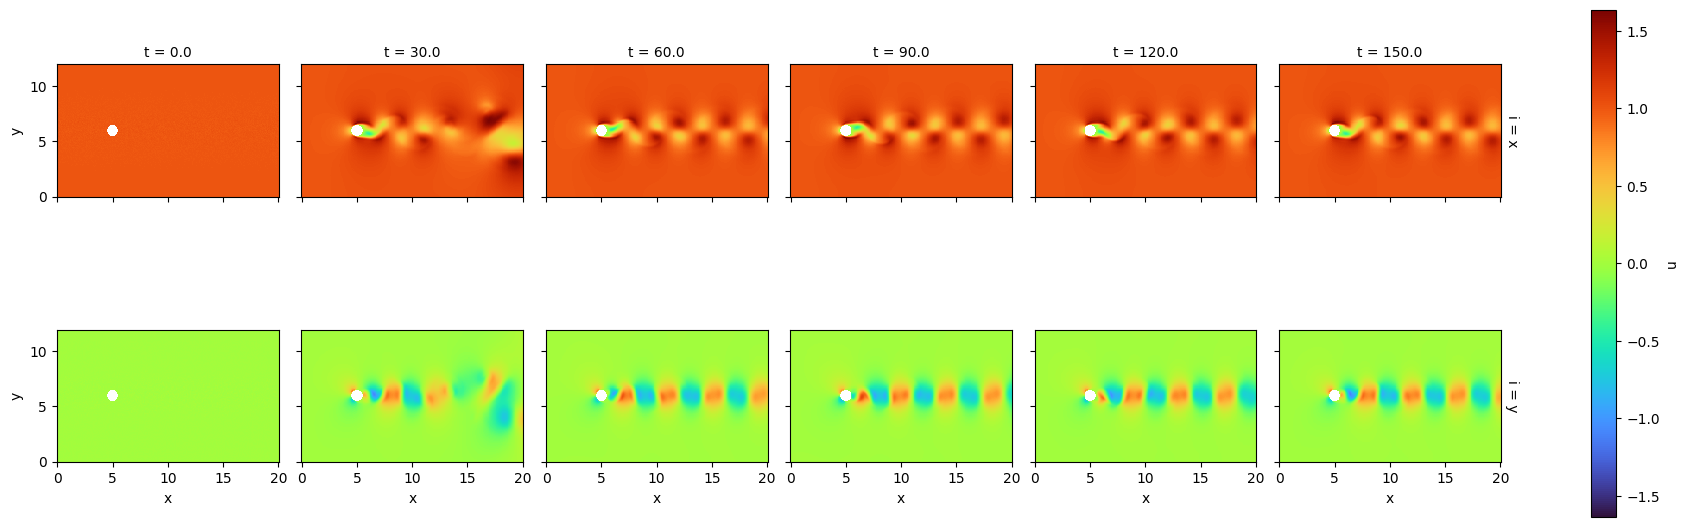

In [17]:
g = dataset.u.isel(t=slice(None, None, 40)).plot(x="x", y="y", col="t", row="i", cmap="turbo", rasterized=True)

for ax in g.axes.flat:
    ax.axes.set_aspect("equal")

Como exemplo de computação paralela, calcula-se a vorticidade para o banco de dados. Para uma configuração bidimensional a equação da vorticidade pode ser escrita da forma:

$$
\omega_z = \dfrac{\partial u_y}{\partial x}  - \dfrac{\partial u_x}{\partial y}.
$$

Pode-se usar [xarray.DataArray.differentiate](http://docs.xarray.dev/en/stable/generated/xarray.DataArray.differentiate.html) com uma derivada centrada de 2th ordem. Todavia, há a opção de usar um esquema de 4th ordem disponível em [X3dDataArray.first_derivative](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.array.X3dDataArray.first_derivative).

Primeiro se define o atributo da condição de contorno para o campo de velocidade:

In [18]:
dataset["u"].attrs["BC"] = prm.get_boundary_condition("u")

e calcular a vorticidade:

In [19]:
%%time
dataset["vort"] = dataset.u.sel(i="y").x3d.first_derivative("x") - dataset.u.sel(i="x").x3d.first_derivative("y")

CPU times: user 1.25 s, sys: 59.1 ms, total: 1.31 s
Wall time: 1.33 s


Lembrando que a equação acima cálcula a vorticidade para toda a serie temporal.

O método [X3dDataArray.pencil_decomp](https://docs.fschuch.com/xcompact3d_toolbox/references/api-reference.html#xcompact3d_toolbox.array.X3dDataArray.pencil_decomp) pode ser usado para converter o campo de velocidade para um array dask para computação paralela (veja [Using Dask with xarray](http://docs.xarray.dev/en/stable/user-guide/dask.html#using-dask-with-xarray)).

Como exemplo, divide-se o domínio t em 4 pencils que podem ser resolvidos por 4 núcleos em paralelo.

In [21]:
u_chunked = dataset.u.chunk(chunks={"t": 51})
u_chunked

<xarray.DataArray 'u' (i: 2, x: 257, y: 128, t: 201)> Size: 53MB
dask.array<xarray-<this-array>, shape=(2, 257, 128, 201), dtype=float32, chunksize=(2, 257, 128, 51), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2kB 0.0 0.07812 0.1562 0.2344 ... 19.84 19.92 20.0
  * y        (y) float64 1kB 0.0 0.09375 0.1875 0.2812 ... 11.72 11.81 11.91
  * t        (t) float64 2kB 0.0 0.75 1.5 2.25 3.0 ... 147.8 148.5 149.2 150.0
  * i        (i) <U1 8B 'x' 'y'
Attributes:
    BC:       {'x': {'ncl1': 2, 'ncln': 2, 'npaire': 1}, 'y': {'ncl1': 0, 'nc...

Cálculando a vorticidade em paralelo:

In [22]:
%%time
dataset["vort"] = (
    u_chunked.sel(i="y").x3d.first_derivative("x") - u_chunked.sel(i="x").x3d.first_derivative("y")
).compute()

CPU times: user 3.66 s, sys: 740 ms, total: 4.4 s
Wall time: 4.71 s


Não houve uma melhora de performance devido a ser um banco de dados muito pequeno o que não compensa a sobrecarga para utilizar o paralelismo. Porém, pode-se utilizar esse código para escalar para simulações maiores.

Novamente, pode-se definir atributos para a grandeza computada.

In [23]:
dataset["vort"].attrs = {"name": "wz", "long_name": "Vorticity", "units": "-"}

E a partir dela gerar o gráfico:

/tmp/ipython-input-1555947376.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


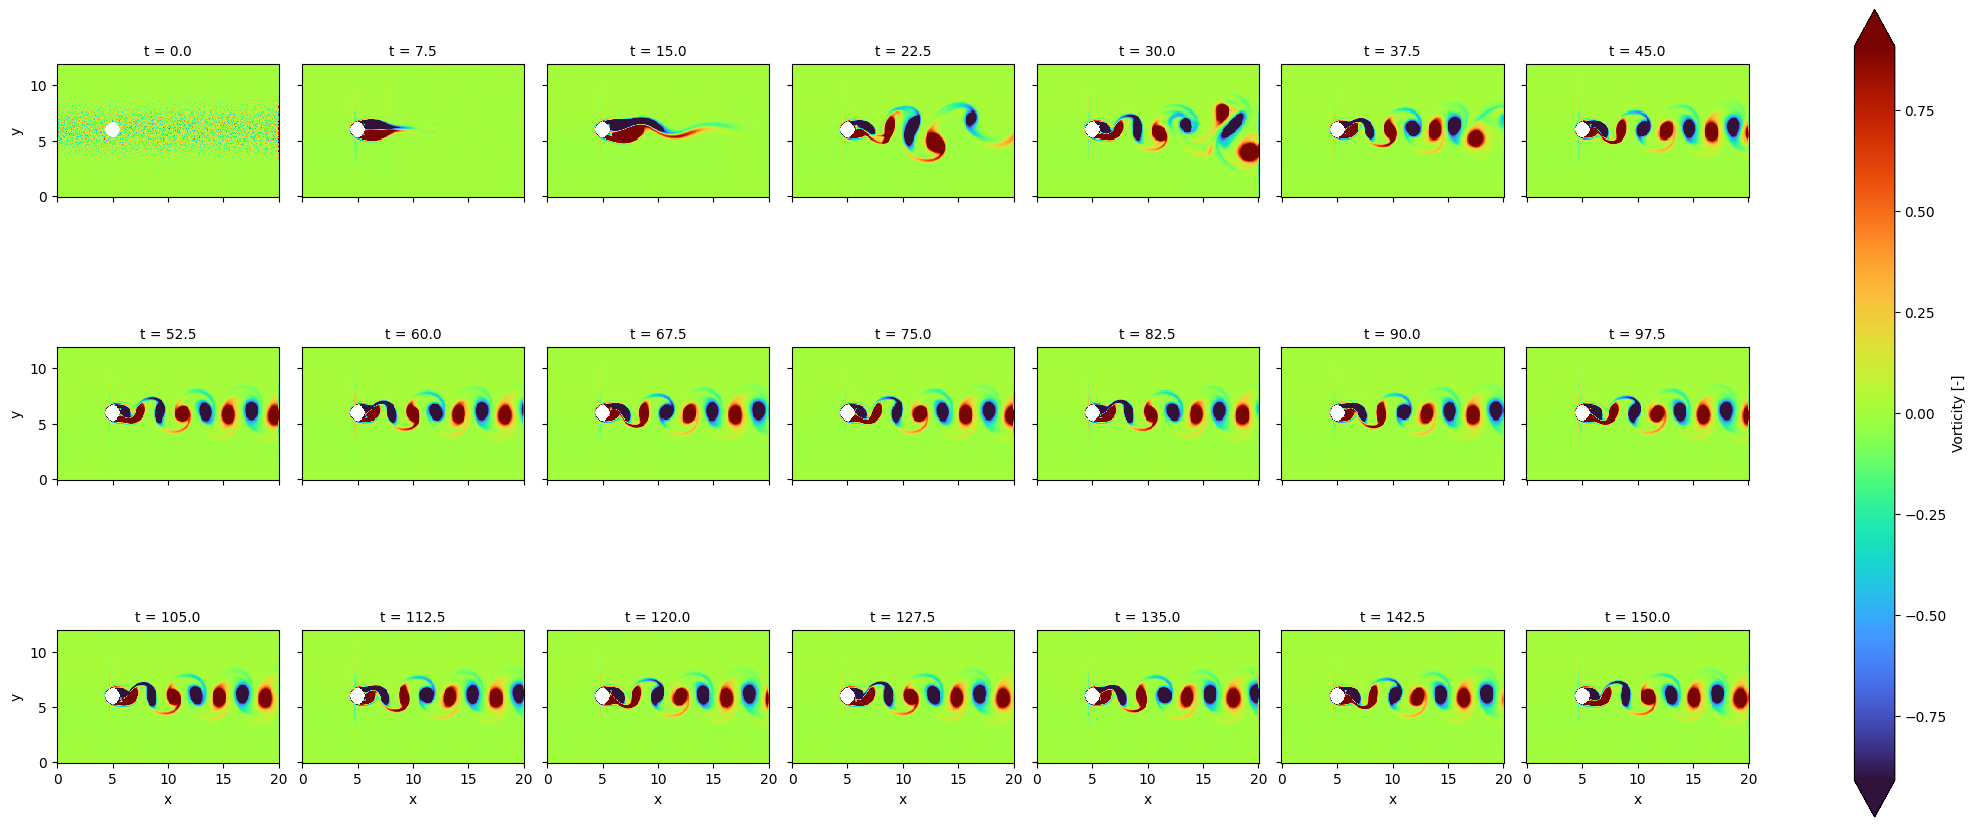

In [24]:
g = dataset.vort.isel(t=slice(None, None, 10)).plot(
    x="x", y="y", col="t", col_wrap=7, cmap="turbo", rasterized=True, robust=True
)
for ax in g.axes.flat:
    ax.axes.set_aspect("equal")

A precisão pode ser melhorada próxima a geométria se o campo for interpolado dentro do cilindro, criando uma função continua antes de aplicar a derivada. Para visualização, pode-se selecionar uma amostra dos dados para que se consiga visualizar em 1D. Para o campo de velocidade, selecionou-se apenas a componente
`x`.

In [27]:
ux_sample = dataset.u.sel(i="x", t=150.0, y=6.0)

Pode-se montar o gráfico para essa amostra com `np.NaN` dentro do cilindro e preenche-la com inside the cylinder, the same data we used in all the previous examples, and we can also [uma interpolação cúbica](http://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html#xarray.DataArray.interpolate_na).

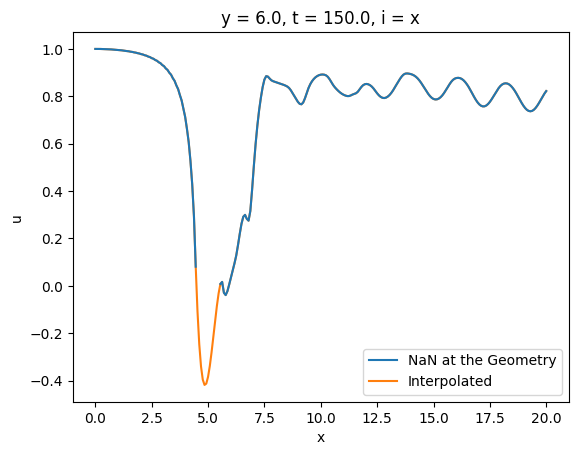

In [28]:
ux_sample.plot(label="NaN at the Geometry")
ux_sample.interpolate_na("x", "cubic").plot(label="Interpolated", zorder=-1)
plt.legend();

Comparando a derivada com e sem a interpolação.

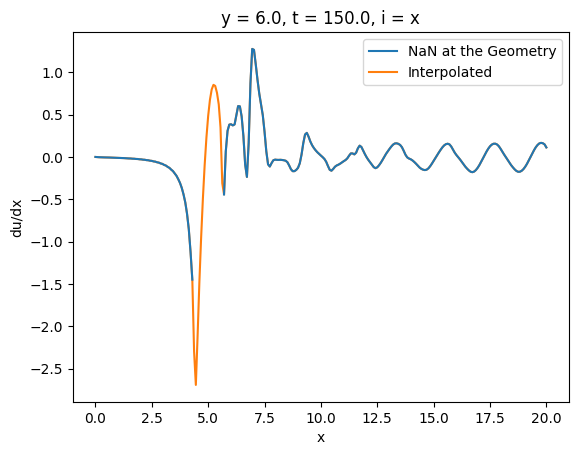

In [30]:
ux_sample.x3d.first_derivative("x").plot(label="NaN at the Geometry")
ux_sample.interpolate_na("x", "cubic").x3d.first_derivative("x").plot(label="Interpolated", zorder=-1)
plt.ylabel("du/dx")
plt.legend();

[xarray](http://docs.xarray.dev/en/stable/) é construído sobre [Numpy](https://numpy.org/), seus arrays e datasets são compatíveis com várias ferramentas Numpy/SciPy.
Você pode acessar `numpy.ndarray` objetos com a propriedade `values`:

In [31]:
dataset.epsi.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Veja também:

* [Xarray: How do I ...](http://docs.xarray.dev/en/stable/howdoi.html)
* [Xarray's tutorials](https://xarray-contrib.github.io/xarray-tutorial/)
* [python-xarray](https://stackoverflow.com/questions/tagged/python-xarray) no StackOverflow
* [pint-xarray](https://pint-xarray.readthedocs.io/en/latest/) Pint permite converter unidades em Python

### Visualização interativa

In [32]:
import hvplot.xarray  # noqa: F401

ModuleNotFoundError: No module named 'hvplot'

<div class="alert alert-info">

For an interactive experience [launch this tutorial on Binder](https://mybinder.org/v2/gh/fschuch/xcompact3d_toolbox/main?urlpath=lab/tree/docs/tutorial/computing_and_plotting.ipynb), the widgets are not responsive when disconnected from a Python application.

</div>

All the previous examples where based on matplotlib, but xarray is compatible with more options.
One of them is [hvPlot](https://hvplot.holoviz.org/index.html) (see [Gridded Data](https://hvplot.holoviz.org/user_guide/Gridded_Data.html)).

hvPlot is recommended when you are exploring your data and need a bit more interactivity.

To exemplify, let's reproduce one of the figure we did before, choosing one specific location in our mesh and looking at the time evolution of the velocity there:

In [ ]:
dataset.u.sel(x=10.0, y=6.0, method="nearest").hvplot(x="t", by="i")

One key aspect about hvPlot is that when it gets more coordinates than it can handle in a plot, it presents the extra coordinates in widgets. So if we do not select any specific point in the domain and reproduce the same figure above, we will get widgets to select the point where we are looking:

In [ ]:
dataset.u.hvplot(x="t", by="i", widget_location="bottom")

Here we reproduce the time evolution of the kinetic energy, this time with hvPlot:

In [ ]:
dataset["kinetic_energy"].hvplot()

And one last example, we can see a really nice animation of the vorticity field, here in a Jupyter Notebook, with a very few lines of code:

In [ ]:
dataset.vort.sel(t=slice(40, None)).hvplot(
    x="x",
    y="y",
    aspect="equal",
    clim=(-5, 5),
    rasterize=True,
    cmap="turbo",
    widget_type="scrubber",
    widget_location="bottom",
    title="Flow around a Cylinder",
    clabel=r"Vorticity [-]",
)

Note: The selection (`sel(t = slice(40, None))`) in the block above is not necessary, of course, we can see the animation since the beginning. It was just used to look better at readthedocs.